In [1]:
import pprint
import time
from pathlib import Path

import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import torch
from hydra import compose, initialize
from matplotlib import pyplot as plt
from omegaconf import OmegaConf
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from src.groupkfold import GroupKFoldWithSeed
from src.seed import seed_everything
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from tqdm.auto import tqdm
from transformers import AutoModel, AutoTokenizer

with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 20
    bagging_fraction: 0.9
    bagging_freq: 1
    feature_fraction: 0.9
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 500
  log_evaluation: 100
  num_boost_round: 10000000
exp_number: '007'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  cloth_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/007/base
seed: 42
n_splits: 5
target: Recommended IND



### Import

In [2]:
train_df = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
cloth_df = pl.read_csv(cfg.data.cloth_path, try_parse_dates=True)
test_df = pl.read_csv(cfg.data.test_path, try_parse_dates=True)

train_df = train_df.join(cloth_df, on="Clothing ID", how="left")
test_df = test_df.join(cloth_df, on="Clothing ID", how="left")
train_test_df = pl.concat([train_df, test_df], how="diagonal")

skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)

train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
i64,i64,str,str,i64,i64,i64,str,str,str
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts"""
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts"""
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts"""
0,45,null,"""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts"""
0,57,"""Unique, pretty asymmetric skir…","""I saw this skirt in retailer s…",5,1,1,"""General""","""Bottoms""","""Skirts"""


### paoさんのベースラインを参考にテキストのEmbeddingを作る
- https://www.guruguru.science/competitions/24/discussions/b0d46909-1ebc-4b14-a91e-569fcf3d5e27/

In [3]:
MODEL_ID = "intfloat/multilingual-e5-large"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModel.from_pretrained(MODEL_ID).to(device)


In [4]:
# 前処理(欠損をnoneという文字列で埋めておく)
train_test_df = train_test_df.with_columns(pl.col("Title").fill_null("none"), pl.col("Review Text").fill_null("none"))


In [5]:
# Title列とReview Text列を結合し、それぞれの前にラベルを追加した新たな列を作成
train_test_df = train_test_df.with_columns(
    pl.concat_str(
        [pl.lit("TITLE: "), pl.col("Title"), pl.lit(" [SEP] "), pl.lit(" Review Text: "), pl.col("Review Text")]
    ).alias("text")
)

print(train_test_df.select("Title", "Review Text", "text").head())


shape: (5, 3)
┌────────────────────────────┬──────────────────────────────────┬──────────────────────────────────┐
│ Title                      ┆ Review Text                      ┆ text                             │
│ ---                        ┆ ---                              ┆ ---                              │
│ str                        ┆ str                              ┆ str                              │
╞════════════════════════════╪══════════════════════════════════╪══════════════════════════════════╡
│ 3-season skirt!            ┆ Adorable, well-made skirt! lin…  ┆ TITLE: 3-season skirt! [SEP]  …  │
│ Very cute                  ┆ Love the asymmetrical hem. wai…  ┆ TITLE: Very cute [SEP]  Review…  │
│ Beautiful! fruns small for ┆ I love this skirt! i wasn't su…  ┆ TITLE: Beautiful! fruns small …  │
│ typ…                       ┆                                  ┆                                  │
│ none                       ┆ I was really pleased with this…  ┆ TITLE: none

In [6]:
train_test_df["text"][0]


"TITLE: 3-season skirt! [SEP]  Review Text: Adorable, well-made skirt! lined and very slimming. i had to size up b/c it runs a bit snug around the waist. however, it's worth it b/c this will match many long and short sleeve tops!"

In [7]:
# token長を確認 --> max_length 192とかで大丈夫そう
train_test_df.select(pl.col("text").map_elements(lambda x: len(tokenizer(x)["input_ids"]))).max()


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


text
i64
185


In [8]:
class EmbDataset(Dataset):
    def __init__(self, texts, max_length=192):
        self.texts = texts
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        token = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,  # TODO: 何を意味しているの調べる
            return_token_type_ids=True,  # TODO: 何を意味しているの調
        )
        return {
            "input_ids": torch.LongTensor(token["input_ids"]),
            "attention_mask": torch.LongTensor(token["attention_mask"]),
            "token_type_ids": torch.LongTensor(token["token_type_ids"]),
        }


In [9]:
train_test_df["text"].to_numpy()[:10]


array(["TITLE: 3-season skirt! [SEP]  Review Text: Adorable, well-made skirt! lined and very slimming. i had to size up b/c it runs a bit snug around the waist. however, it's worth it b/c this will match many long and short sleeve tops!",
       "TITLE: Very cute [SEP]  Review Text: Love the asymmetrical hem. waist fit snugly as in perfectly. it ties in two spots with a hidden zipper as well. a little stiff in the fabric. classic colors but decided not to keep only because i didn't feel like we could wear it all year round.  can't petite or 0p was great (115 lbs)",
       'TITLE: Beautiful! fruns small for typical retailer sizing [SEP]  Review Text: I love this skirt! i wasn\'t sure about the mix of the back pattern with the front but it works! it is great for work at a less conservative place and for dinners out too! the quality is great - the skirt is a fine silk, ant it is lined, so you don\'t need a slip. i think it fits perfectly for my body type, and while it runs big compared to

In [15]:
# embeddingsを作成
embeddings = []
emb_list = []
dataset = EmbDataset(train_test_df["text"].to_numpy(), max_length=192)
data_loader = DataLoader(dataset, batch_size=256, num_workers=0, shuffle=False)
bar = tqdm(enumerate(data_loader), total=len(data_loader))

for _, batch in bar:
    # input
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)

    # forward
    with torch.no_grad():
        last_hidden_state, pooler_output, hidden_state = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            return_dict=False,
        )
        batch_embs = last_hidden_state.mean(dim=1)

    emb_list.append(batch_embs.detach().cpu().numpy())

embeddings = np.concatenate(emb_list)


  0%|          | 0/83 [00:00<?, ?it/s]

In [16]:
# embeddingsをデータフレームに変換
embeddings_df = pl.DataFrame(embeddings).rename(
    {col: f"text_emb_{i}" for i, col in enumerate(pl.DataFrame(embeddings).columns)}
)

# train_test_dfに結合
train_test_df = pl.concat([train_test_df, embeddings_df], how="horizontal")

train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,…,text_emb_987,text_emb_988,text_emb_989,text_emb_990,text_emb_991,text_emb_992,text_emb_993,text_emb_994,text_emb_995,text_emb_996,text_emb_997,text_emb_998,text_emb_999,text_emb_1000,text_emb_1001,text_emb_1002,text_emb_1003,text_emb_1004,text_emb_1005,text_emb_1006,text_emb_1007,text_emb_1008,text_emb_1009,text_emb_1010,text_emb_1011,text_emb_1012,text_emb_1013,text_emb_1014,text_emb_1015,text_emb_1016,text_emb_1017,text_emb_1018,text_emb_1019,text_emb_1020,text_emb_1021,text_emb_1022,text_emb_1023
i64,i64,str,str,i64,i64,i64,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""","""TITLE: 3-season skirt! [SEP] …",0.242821,0.488743,-1.31583,-1.274316,1.041399,-1.441048,-0.540368,1.661724,0.419062,-0.004628,0.85121,1.492484,-1.558105,-0.596693,-0.968334,-0.04507,-0.291986,0.575769,0.200177,-0.368055,1.192803,-1.104699,-1.127475,-1.355138,-1.131496,-0.07575,…,-0.471067,-0.456641,1.340147,1.264878,-0.140183,0.649519,1.543641,1.31349,-0.298302,0.760671,-0.39975,-0.735861,0.821986,0.574387,0.815813,-0.395828,-0.055643,-0.443571,-0.497655,-0.978772,0.962651,-1.753652,0.165759,-0.135459,0.996062,0.437807,0.142689,-0.680225,-0.267326,0.960756,-0.025597,0.4277,0.66943,0.443269,-0.340265,0.146787,0.348182
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""","""TITLE: Very cute [SEP] Review…",0.359824,0.344891,-0.80481,-1.077225,0.654805,-1.803349,-0.483349,1.830331,0.979952,0.303393,1.019763,0.898883,-1.793428,-1.092888,-1.014405,0.453123,-0.792485,0.541545,0.028093,0.330734,1.074427,-0.970882,-1.225293,-1.321165,-1.249368,0.002754,…,0.068449,-0.148706,1.398497,1.366886,0.315786,0.856216,1.13408,1.322257,-0.235173,0.983045,0.07763,-0.501502,0.600222,0.915663,0.316193,-0.853341,0.146756,-1.004483,0.547845,-0.956541,0.678353,-0.842835,0.372046,-0.426535,0.92899,0.933901,0.89056,-0.48256,-0.303021,0.615743,0.433827,0.307709,0.968137,0.040957,-0.203582,-0.587249,0.480844
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""","""TITLE: Beautiful! fruns small …",0.640424,-0.116657,-0.762265,-0.712672,0.700389,-0.53762,-0.941259,0.963776,1.327995,0.212955,0.885705,1.396799,-0.854882,-0.373929,-1.190505,0.134767,-0.571501,0.462964,-0.084842,-0.33881,0.791805,-0.451819,-0.830206,-1.276023,-0.936213,-0.176897,…,-0.332806,0.035772,0.760276,0.8369,-0.116801,0.408698,1.542422,1.325804,-0.325598,1.018906,-0.031145,-0.039585,1.14388,0.074802,1.222783,-0.855509,0.156536,-0.399978,-0.146763,-1.248258,0.890357,-0.872993,0.55987,-0.49888,0.48516,0.619237,0.429449,-0.604784,-0.270031,0.561585,0.373538,0.324577,0.371147,0.128053,-0.276045,-0.971827,0.411139
0,45,"""none""","""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts""","""TITLE: none [SEP] Review Text…",0.556583,0.174642,-1.316347,-1.06821,0.847018,-0.853635,0.151001,1.784138,1.432296,-0.285767,1.061524,0.531887,-1.373637,-0.895381,-1.067081,-0.295623,-0.377117,1.093049,0.487533,-0.460937,1.092704,-0.854865,-1.330167,-0.742285,-0.327147,-0.48541,…,-0.192092,-0.206538,1.054647,1.251825,-0.588679,0.787066,1.576364,0.843343,-0.179466,1.258248,-0.402841,0.327261,1.727999,0.648953,1.203201,-0.289156,0.336384,-0.96460

In [40]:
# embeddings_dfをparquetで保存
embeddings_df.write_parquet("exp007_text_embeddings_by_e5.parquet")


In [41]:
# 正常に読み込めるか確認 --> OK
pl.read_parquet("exp007_text_embeddings_by_e5.parquet")



text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,text_emb_26,text_emb_27,text_emb_28,text_emb_29,text_emb_30,text_emb_31,text_emb_32,text_emb_33,text_emb_34,text_emb_35,text_emb_36,…,text_emb_987,text_emb_988,text_emb_989,text_emb_990,text_emb_991,text_emb_992,text_emb_993,text_emb_994,text_emb_995,text_emb_996,text_emb_997,text_emb_998,text_emb_999,text_emb_1000,text_emb_1001,text_emb_1002,text_emb_1003,text_emb_1004,text_emb_1005,text_emb_1006,text_emb_1007,text_emb_1008,text_emb_1009,text_emb_1010,text_emb_1011,text_emb_1012,text_emb_1013,text_emb_1014,text_emb_1015,text_emb_1016,text_emb_1017,text_emb_1018,text_emb_1019,text_emb_1020,text_emb_1021,text_emb_1022,text_emb_1023
f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0.242821,0.488743,-1.31583,-1.274316,1.041399,-1.441048,-0.540368,1.661724,0.419062,-0.004628,0.85121,1.492484,-1.558105,-0.596693,-0.968334,-0.04507,-0.291986,0.575769,0.200177,-0.368055,1.192803,-1.104699,-1.127475,-1.355138,-1.131496,-0.07575,-0.558422,-0.70573,-0.170285,-0.922971,0.144718,0.047105,-0.809663,-0.808777,0.107342,0.555277,0.873926,…,-0.471067,-0.456641,1.340147,1.264878,-0.140183,0.649519,1.543641,1.31349,-0.298302,0.760671,-0.39975,-0.735861,0.821986,0.574387,0.815813,-0.395828,-0.055643,-0.443571,-0.497655,-0.978772,0.962651,-1.753652,0.165759,-0.135459,0.996062,0.437807,0.142689,-0.680225,-0.267326,0.960756,-0.025597,0.4277,0.66943,0.443269,-0.340265,0.146787,0.348182
0.359824,0.344891,-0.80481,-1.077225,0.654805,-1.803349,-0.483349,1.830331,0.979952,0.303393,1.019763,0.898883,-1.793428,-1.092888,-1.014405,0.453123,-0.792485,0.541545,0.028093,0.330734,1.074427,-0.970882,-1.225293,-1.321165,-1.249368,0.002754,-1.054193,-1.011238,-0.844451,-0.565298,-0.761024,0.378335,-0.942773,-1.492099,-0.311857,0.397757,1.13467,…,0.068449,-0.148706,1.398497,1.366886,0.315786,0.856216,1.13408,1.322257,-0.235173,0.983045,0.07763,-0.501502,0.600222,0.915663,0.316193,-0.853341,0.146756,-1.004483,0.547845,-0.956541,0.678353,-0.842835,0.372046,-0.426535,0.92899,0.933901,0.89056,-0.48256,-0.303021,0.615743,0.433827,0.307709,0.968137,0.040957,-0.203582,-0.587249,0.480844
0.640424,-0.116657,-0.762265,-0.712672,0.700389,-0.53762,-0.941259,0.963776,1.327995,0.212955,0.885705,1.396799,-0.854882,-0.373929,-1.190505,0.134767,-0.571501,0.462964,-0.084842,-0.33881,0.791805,-0.451819,-0.830206,-1.276023,-0.936213,-0.176897,-0.81016,-1.278353,-0.663528,-0.885743,-0.415953,0.502789,-0.810455,-0.546524,-0.074953,-0.242944,0.790548,…,-0.332806,0.035772,0.760276,0.8369,-0.116801,0.408698,1.542422,1.325804,-0.325598,1.018906,-0.031145,-0.039585,1.14388,0.074802,1.222783,-0.855509,0.156536,-0.399978,-0.146763,-1.248258,0.890357,-0.872993,0.55987,-0.49888,0.48516,0.619237,0.429449,-0.604784,-0.270031,0.561585,0.373538,0.324577,0.371147,0.128053,-0.276045,-0.971827,0.411139
0.556583,0.174642,-1.316347,-1.06821,0.847018,-0.853635,0.151001,1.784138,1.432296,-0.285767,1.061524,0.531887,-1.373637,-0.895381,-1.067081,-0.295623,-0.377117,1.093049,0.487533,-0.460937,1.092704,-0.854865,-1.330167,-0.742285,-0.327147,-0.48541,-0.855634,-1.345798,-0.223023,-1.038474,0.142618,0.462394,-1.236222,-0.733841,-0.061591,0.602615,1.080203,…,-0.192092,-0.206538,1.054647,1.251825,-0.588679,0.787066,1.576364,0.843343,-0.179466,1.258248,-0.402841,0.327261,1.727999,0.648953,1.203201,-0.289156,0.336384,-0.964602,0.959179,-0.4669,0.958892,-1.18381,0.283095,-0.560689,0.41506,0.684444,0.871787,-0.48433,-0.276929,0.31021,0.291257,-0.176003,0.669903,0.342831,-1.0

### 特徴量加工

In [17]:
# テキストデータ由来の特徴量

# CountVectorizer + 次元削減

count_svd = Pipeline(
    steps=[
        ("CountVectorizer", CountVectorizer()),
        ("TruncatedSVD", TruncatedSVD(n_components=50, random_state=cfg.seed)),
    ]
)

count_nmf = Pipeline(
    steps=[
        ("CountVectorizer", CountVectorizer()),
        ("NMF", NMF(n_components=50, random_state=cfg.seed)),
    ]
)

count_lda = Pipeline(
    steps=[
        ("CountVectorizer", CountVectorizer()),
        ("LDA", LatentDirichletAllocation(n_components=50, random_state=cfg.seed)),
    ]
)

title_features_count_svd = count_svd.fit_transform(train_test_df["Title"].fill_null(""))
title_features_count_nmf = count_nmf.fit_transform(train_test_df["Title"].fill_null(""))
title_features_count_lda = count_lda.fit_transform(train_test_df["Title"].fill_null(""))

review_text_features_count_svd = count_svd.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_count_nmf = count_nmf.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_count_lda = count_lda.fit_transform(train_test_df["Review Text"].fill_null(""))


In [18]:
# TfidfVectorizer + 次元削減

tfidf_svd = Pipeline(
    steps=[
        ("TfidfVectorizer", TfidfVectorizer()),
        ("TruncatedSVD", TruncatedSVD(n_components=50, random_state=cfg.seed)),
    ]
)

tfidf_nmf = Pipeline(
    steps=[("TfidfVectorizer", TfidfVectorizer()), ("NMF", NMF(n_components=50, random_state=cfg.seed))]
)

tfidf_lda = Pipeline(
    steps=[
        ("TfidfVectorizer", TfidfVectorizer()),
        ("LDA", LatentDirichletAllocation(n_components=50, random_state=cfg.seed)),
    ]
)

title_features_tfidf_svd = tfidf_svd.fit_transform(train_test_df["Title"].fill_null(""))
title_features_tfidf_nmf = tfidf_nmf.fit_transform(train_test_df["Title"].fill_null(""))
title_features_tfidf_lda = tfidf_lda.fit_transform(train_test_df["Title"].fill_null(""))

review_text_features_tfidf_svd = tfidf_svd.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_tfidf_nmf = tfidf_nmf.fit_transform(train_test_df["Review Text"].fill_null(""))
review_text_features_tfidf_lda = tfidf_lda.fit_transform(train_test_df["Review Text"].fill_null(""))


In [19]:
# 特徴量をデータフレームに変換してtrain_test_dfに結合

title_features_count_svd_df = pl.DataFrame(title_features_count_svd).rename(
    {col: f"title_count_svd_{i}" for i, col in enumerate(pl.DataFrame(title_features_count_svd).columns)}
)

title_features_count_nmf_df = pl.DataFrame(title_features_count_nmf).rename(
    {col: f"title_count_nmf_{i}" for i, col in enumerate(pl.DataFrame(title_features_count_nmf).columns)}
)

title_features_count_lda_df = pl.DataFrame(title_features_count_lda).rename(
    {col: f"title_count_lda_{i}" for i, col in enumerate(pl.DataFrame(title_features_count_lda).columns)}
)

title_features_tfidf_svd_df = pl.DataFrame(title_features_tfidf_svd).rename(
    {col: f"title_tfidf_svd_{i}" for i, col in enumerate(pl.DataFrame(title_features_tfidf_svd).columns)}
)

title_features_tfidf_nmf_df = pl.DataFrame(title_features_tfidf_nmf).rename(
    {col: f"title_tfidf_nmf_{i}" for i, col in enumerate(pl.DataFrame(title_features_tfidf_nmf).columns)}
)

title_features_tfidf_lda_df = pl.DataFrame(title_features_tfidf_lda).rename(
    {col: f"title_tfidf_lda_{i}" for i, col in enumerate(pl.DataFrame(title_features_tfidf_lda).columns)}
)

review_text_features_count_svd_df = pl.DataFrame(review_text_features_count_svd).rename(
    {col: f"review_text_count_svd_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_count_svd).columns)}
)

review_text_features_count_nmf_df = pl.DataFrame(review_text_features_count_nmf).rename(
    {col: f"review_text_count_nmf_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_count_nmf).columns)}
)

review_text_features_count_lda_df = pl.DataFrame(review_text_features_count_lda).rename(
    {col: f"review_text_count_lda_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_count_lda).columns)}
)

review_text_features_tfidf_svd_df = pl.DataFrame(review_text_features_tfidf_svd).rename(
    {col: f"review_text_tfidf_svd_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_tfidf_svd).columns)}
)

review_text_features_tfidf_nmf_df = pl.DataFrame(review_text_features_tfidf_nmf).rename(
    {col: f"review_text_tfidf_nmf_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_tfidf_nmf).columns)}
)

review_text_features_tfidf_lda_df = pl.DataFrame(review_text_features_tfidf_lda).rename(
    {col: f"review_text_tfidf_lda_{i}" for i, col in enumerate(pl.DataFrame(review_text_features_tfidf_lda).columns)}
)

train_test_df = pl.concat(
    [
        train_test_df,
        title_features_count_svd_df,
        title_features_count_nmf_df,
        title_features_count_lda_df,
        title_features_tfidf_svd_df,
        title_features_tfidf_nmf_df,
        title_features_tfidf_lda_df,
        review_text_features_count_svd_df,
        review_text_features_count_nmf_df,
        review_text_features_count_lda_df,
        review_text_features_tfidf_svd_df,
        review_text_features_tfidf_nmf_df,
        review_text_features_tfidf_lda_df,
    ],
    how="horizontal",
)


In [44]:
# CountVectorizer + 次元削減, TfidfVectorizer + 次元削減の結果を保存しておく
count_tfidf_dim_reduction_df = pl.concat(
    [
        title_features_count_svd_df,
        title_features_count_nmf_df,
        title_features_count_lda_df,
        title_features_tfidf_svd_df,
        title_features_tfidf_nmf_df,
        title_features_tfidf_lda_df,
        review_text_features_count_svd_df,
        review_text_features_count_nmf_df,
        review_text_features_count_lda_df,
        review_text_features_tfidf_svd_df,
        review_text_features_tfidf_nmf_df,
        review_text_features_tfidf_lda_df,
    ],
    how="horizontal",
)

count_tfidf_dim_reduction_df.write_parquet("exp007_count_tfidf_dim_reduction.parquet")

# 正常に読み込めるか確認 --> OK
pl.read_parquet("exp007_count_tfidf_dim_reduction.parquet")



title_count_svd_0,title_count_svd_1,title_count_svd_2,title_count_svd_3,title_count_svd_4,title_count_svd_5,title_count_svd_6,title_count_svd_7,title_count_svd_8,title_count_svd_9,title_count_svd_10,title_count_svd_11,title_count_svd_12,title_count_svd_13,title_count_svd_14,title_count_svd_15,title_count_svd_16,title_count_svd_17,title_count_svd_18,title_count_svd_19,title_count_svd_20,title_count_svd_21,title_count_svd_22,title_count_svd_23,title_count_svd_24,title_count_svd_25,title_count_svd_26,title_count_svd_27,title_count_svd_28,title_count_svd_29,title_count_svd_30,title_count_svd_31,title_count_svd_32,title_count_svd_33,title_count_svd_34,title_count_svd_35,title_count_svd_36,…,review_text_tfidf_lda_13,review_text_tfidf_lda_14,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-8.4184e-9,0.025195,-0.00648,0.012603,0.003142,0.012205,-0.000845,0.005963,0.010226,0.010625,-0.016422,0.011638,-0.046953,0.037804,-0.007307,0.002761,0.015462,0.018859,0.005048,-0.013881,-0.037571,-0.011291,-0.003873,0.027113,0.024636,0.049132,0.029452,0.011828,-0.077913,-0.001067,0.006617,-0.017796,-0.024418,0.012088,-0.039239,-0.057757,0.157153,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275
1.0733e-9,0.281643,-0.351227,-0.346093,-0.24019,-0.002059,0.730324,-0.178152,0.098685,0.072573,-0.328557,-0.013503,-0.100265,-0.006384,0.358344,0.4168,0.372994,0.431628,-0.048599,-0.004924,0.000416,-0.219021,0.250921,-0.07194,0.059472,0.081563,-0.36156,0.062582,0.080521,0.027424,0.012045,-0.050323,-0.024232,-0.011752,-0.00971,-0.018916,-0.003529,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.741221,0.002717,0.002717,0.002717,0.002717,0.036691,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.094366,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717
1.7908e-10,0.380641,-0.356156,0.127208,-0.190442,-0.359637,-0.624296,0.276109,0.46286,-0.336003,-0.553739,0.222192,-0.241278,0.069329,0.040853,0.555196,-0.216826,-0.109378,-0.104466,0.030026,-0.024511,0.053222,-0.213231,-0.001464,-0.054677,-0.030431,0.100583,0.010373,-0.075386,-0.033666,-0.001566,0.111324,-0.04419,-0.062209,-0.050762,0.036282,0.015564,…,0.002375,0.029709,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.792022,0.002375,0.002375,0.031642,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375
1.0,1.3108e-13,2.5301e-13,

In [20]:
train_test_df.head()


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,…,review_text_tfidf_lda_13,review_text_tfidf_lda_14,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49
i64,i64,str,str,i64,i64,i64,str,str,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,"""General""","""Bottoms""","""Skirts""","""TITLE: 3-season skirt! [SEP] …",0.242821,0.488743,-1.31583,-1.274316,1.041399,-1.441048,-0.540368,1.661724,0.419062,-0.004628,0.85121,1.492484,-1.558105,-0.596693,-0.968334,-0.04507,-0.291986,0.575769,0.200177,-0.368055,1.192803,-1.104699,-1.127475,-1.355138,-1.131496,-0.07575,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,"""General""","""Bottoms""","""Skirts""","""TITLE: Very cute [SEP] Review…",0.359824,0.344891,-0.80481,-1.077225,0.654805,-1.803349,-0.483349,1.830331,0.979952,0.303393,1.019763,0.898883,-1.793428,-1.092888,-1.014405,0.453123,-0.792485,0.541545,0.028093,0.330734,1.074427,-0.970882,-1.225293,-1.321165,-1.249368,0.002754,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.741221,0.002717,0.002717,0.002717,0.002717,0.036691,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.094366,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,"""General""","""Bottoms""","""Skirts""","""TITLE: Beautiful! fruns small …",0.640424,-0.116657,-0.762265,-0.712672,0.700389,-0.53762,-0.941259,0.963776,1.327995,0.212955,0.885705,1.396799,-0.854882,-0.373929,-1.190505,0.134767,-0.571501,0.462964,-0.084842,-0.33881,0.791805,-0.451819,-0.830206,-1.276023,-0.936213,-0.176897,…,0.002375,0.029709,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.792022,0.002375,0.002375,0.031642,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375
0,45,"""none""","""I was really pleased with this…",5,1,9,"""General""","""Bottoms""","""Skirts""","""TITLE: none [SEP] Review Text…",0.556583,0.174642,-1.316

In [21]:
# ラベルエンコーディング

le_division_name = LabelEncoder()
le_division_name.fit(cloth_df["Division Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_division_name.transform(train_test_df["Division Name"])).alias("Division Name")
)

le_department_name = LabelEncoder()
le_department_name.fit(cloth_df["Department Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_department_name.transform(train_test_df["Department Name"])).alias("Department Name")
)

le_class_name = LabelEncoder()
le_class_name.fit(cloth_df["Class Name"])
train_test_df = train_test_df.with_columns(
    pl.Series(le_class_name.transform(train_test_df["Class Name"])).alias("Class Name")
)


In [22]:
display(train_test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,…,review_text_tfidf_lda_13,review_text_tfidf_lda_14,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49
i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,"""TITLE: 3-season skirt! [SEP] …",0.242821,0.488743,-1.31583,-1.274316,1.041399,-1.441048,-0.540368,1.661724,0.419062,-0.004628,0.85121,1.492484,-1.558105,-0.596693,-0.968334,-0.04507,-0.291986,0.575769,0.200177,-0.368055,1.192803,-1.104699,-1.127475,-1.355138,-1.131496,-0.07575,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,"""TITLE: Very cute [SEP] Review…",0.359824,0.344891,-0.80481,-1.077225,0.654805,-1.803349,-0.483349,1.830331,0.979952,0.303393,1.019763,0.898883,-1.793428,-1.092888,-1.014405,0.453123,-0.792485,0.541545,0.028093,0.330734,1.074427,-0.970882,-1.225293,-1.321165,-1.249368,0.002754,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.741221,0.002717,0.002717,0.002717,0.002717,0.036691,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.094366,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,"""TITLE: Beautiful! fruns small …",0.640424,-0.116657,-0.762265,-0.712672,0.700389,-0.53762,-0.941259,0.963776,1.327995,0.212955,0.885705,1.396799,-0.854882,-0.373929,-1.190505,0.134767,-0.571501,0.462964,-0.084842,-0.33881,0.791805,-0.451819,-0.830206,-1.276023,-0.936213,-0.176897,…,0.002375,0.029709,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.792022,0.002375,0.002375,0.031642,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375
0,45,"""none""","""I was really pleased with this…",5,1,9,0,0,12,"""TITLE: none [SEP] Review Text…",0.556583,0.174642,-1.316347,-1.06821,0.847018,-0.853635,0.151001,1.784138,1.432296,-0.285767,1.061524,0.531887,-1.373637,-0.895381,-1.067081,-0.295623,-0.377117

In [23]:
# テキストデータの長さ特徴量
train_test_df = train_test_df.with_columns(
    pl.col("Title").str.len_bytes().alias("title_str_len"),
    pl.col("Review Text").str.len_bytes().alias("review_text_str_len"),
)

display(train_test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,…,review_text_tfidf_lda_15,review_text_tfidf_lda_16,review_text_tfidf_lda_17,review_text_tfidf_lda_18,review_text_tfidf_lda_19,review_text_tfidf_lda_20,review_text_tfidf_lda_21,review_text_tfidf_lda_22,review_text_tfidf_lda_23,review_text_tfidf_lda_24,review_text_tfidf_lda_25,review_text_tfidf_lda_26,review_text_tfidf_lda_27,review_text_tfidf_lda_28,review_text_tfidf_lda_29,review_text_tfidf_lda_30,review_text_tfidf_lda_31,review_text_tfidf_lda_32,review_text_tfidf_lda_33,review_text_tfidf_lda_34,review_text_tfidf_lda_35,review_text_tfidf_lda_36,review_text_tfidf_lda_37,review_text_tfidf_lda_38,review_text_tfidf_lda_39,review_text_tfidf_lda_40,review_text_tfidf_lda_41,review_text_tfidf_lda_42,review_text_tfidf_lda_43,review_text_tfidf_lda_44,review_text_tfidf_lda_45,review_text_tfidf_lda_46,review_text_tfidf_lda_47,review_text_tfidf_lda_48,review_text_tfidf_lda_49,title_str_len,review_text_str_len
i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,"""TITLE: 3-season skirt! [SEP] …",0.242821,0.488743,-1.31583,-1.274316,1.041399,-1.441048,-0.540368,1.661724,0.419062,-0.004628,0.85121,1.492484,-1.558105,-0.596693,-0.968334,-0.04507,-0.291986,0.575769,0.200177,-0.368055,1.192803,-1.104699,-1.127475,-1.355138,-1.131496,-0.07575,…,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.839511,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,0.003275,15,185
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,"""TITLE: Very cute [SEP] Review…",0.359824,0.344891,-0.80481,-1.077225,0.654805,-1.803349,-0.483349,1.830331,0.979952,0.303393,1.019763,0.898883,-1.793428,-1.092888,-1.014405,0.453123,-0.792485,0.541545,0.028093,0.330734,1.074427,-0.970882,-1.225293,-1.321165,-1.249368,0.002754,…,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.741221,0.002717,0.002717,0.002717,0.002717,0.036691,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.094366,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,0.002717,9,285
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,"""TITLE: Beautiful! fruns small …",0.640424,-0.116657,-0.762265,-0.712672,0.700389,-0.53762,-0.941259,0.963776,1.327995,0.212955,0.885705,1.396799,-0.854882,-0.373929,-1.190505,0.134767,-0.571501,0.462964,-0.084842,-0.33881,0.791805,-0.451819,-0.830206,-1.276023,-0.936213,-0.176897,…,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.792022,0.002375,0.002375,0.031642,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,0.002375,50,495
0,45,"""none""","""I was really pleased with this…",5,1,9,0,0,12,"""TITLE: none [SEP] Review Text…",0.556583,0.174642,-1.316347,-1.06821,0.847018,-0.853635,0.151001,1.784138,1.432296,-0.285767,1.061524,0.531887,-1.373637,-0.895381,-1.067081,-0.295623,-0.377117,1.093049,0.487533,-0.460937,1.092704,-0.854865,-1

In [24]:
# 集約特徴量

# Clothing ID毎の集約特徴量
cloth_id_cols = ["Age", "Positive Feedback Count", "title_str_len", "review_text_str_len"]
exprs_cloth_id_max = [pl.col(col).max().over("Clothing ID").name.suffix("_cloth_id_max") for col in cloth_id_cols]
exprs_cloth_id_min = [pl.col(col).min().over("Clothing ID").name.suffix("_cloth_id_min") for col in cloth_id_cols]
exprs_cloth_id_mean = [pl.col(col).mean().over("Clothing ID").name.suffix("_cloth_id_mean") for col in cloth_id_cols]
exprs_cloth_id_sum = [pl.col(col).sum().over("Clothing ID").name.suffix("_cloth_id_sum") for col in cloth_id_cols]

# age毎の集約特徴量
age_cols = ["Positive Feedback Count", "title_str_len", "review_text_str_len"]
exprs_age_max = [pl.col(col).max().over("Age").name.suffix("_age_max") for col in age_cols]
exprs_age_min = [pl.col(col).min().over("Age").name.suffix("_age_min") for col in age_cols]
exprs_age_mean = [pl.col(col).mean().over("Age").name.suffix("_age_mean") for col in age_cols]
exprs_age_sum = [pl.col(col).sum().over("Age").name.suffix("_age_sum") for col in age_cols]

# Positive Feedback Count毎の集約特徴量
positive_feedback_count_cols = ["Age", "title_str_len", "review_text_str_len"]
exprs_positive_feedback_count_max = [
    pl.col(col).max().over("Positive Feedback Count").name.suffix("_positive_feedback_count_max")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_min = [
    pl.col(col).min().over("Positive Feedback Count").name.suffix("_positive_feedback_count_min")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_mean = [
    pl.col(col).mean().over("Positive Feedback Count").name.suffix("_positive_feedback_count_mean")
    for col in positive_feedback_count_cols
]
exprs_positive_feedback_count_sum = [
    pl.col(col).sum().over("Positive Feedback Count").name.suffix("_positive_feedback_count_sum")
    for col in positive_feedback_count_cols
]


train_test_df = train_test_df.with_columns(
    exprs_cloth_id_max
    + exprs_cloth_id_min
    + exprs_cloth_id_mean
    + exprs_cloth_id_sum
    + exprs_age_max
    + exprs_age_min
    + exprs_age_mean
    + exprs_age_sum
    + exprs_positive_feedback_count_max
    + exprs_positive_feedback_count_min
    + exprs_positive_feedback_count_mean
    + exprs_positive_feedback_count_sum
)


In [25]:
display(train_test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,"""TITLE: 3-season skirt! [SEP] …",0.242821,0.488743,-1.31583,-1.274316,1.041399,-1.441048,-0.540368,1.661724,0.419062,-0.004628,0.85121,1.492484,-1.558105,-0.596693,-0.968334,-0.04507,-0.291986,0.575769,0.200177,-0.368055,1.192803,-1.104699,-1.127475,-1.355138,-1.131496,-0.07575,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,30,50,502,0,4,4,1.711268,16.90493,277.989437,486,4801,78949,99,52,504,19,2,4,44.336957,17.634058,316.960145,36711,14601,262443
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,"""TITLE: Very cute [SEP] Review…",0.359824,0.344891,-0.80481,-1.077225,0.654805,-1.803349,-0.483349,1.830331,0.979952,0.303393,1.019763,0.898883,-1.793428,-1.092888,-1.014405,0.453123,-0.792485,0.541545,0.028093,0.330734,1.074427,-0.970882,-1.225293,-1.321165,-1.249368,0.002754,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,94,50,504,0,2,4,2.860384,16.532286,285.963351,3278,18946,327714,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,"""TITLE: Beautiful! fruns small …",0.640424,-0.116657,-0.762265,-0.712672,0.700389,-0.53762,-0.941259,0.963776,1.327995,0.212955,0.885705,1.396799,-0.854882,-0.373929,-1.190505,0.134767,-0.571501,0.462964,-0.084842,-0.33881,0.791805,-0.451819,-0.830206,-1.276023,-0.936213,-0.176897,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,68,50,505,0,3,4,2.828619,16.787022,273.667221,1700,10089,164474,83,50,506,20,2,4,44.471667,17.961667,327.558333,26683,10777,196535
0,45,"""none""","""I was really pleased with this…",5,1,9,0,0,12,"""TITLE: none [SEP] Review Text…",0.556583,0.174642,-1.316347,-1.06821,0.847018,-0.853635,0.151001,1.784138,1.432296,-0.285767,1.061524,0.531887,-1.373637,-0.895381,-1.067081,-0.295623,-0.377117,1.093049,0.487533,-0.460937,1.092704,-0.854865,-1.330167,-0.742285,-0.327147,-0.48541,…,502,25,0,4,4,45.285714,2.809524,18.523

### 学習

In [26]:
train_df = train_test_df.filter(pl.col("Rating").is_not_null())
test_df = train_test_df.filter(pl.col("Rating").is_null()).drop(["Rating", cfg.target])

display(train_df.head())
display(test_df.head())


Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,text,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,i64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,25,"""3-season skirt!""","""Adorable, well-made skirt! lin…",5,1,4,0,0,12,"""TITLE: 3-season skirt! [SEP] …",0.242821,0.488743,-1.31583,-1.274316,1.041399,-1.441048,-0.540368,1.661724,0.419062,-0.004628,0.85121,1.492484,-1.558105,-0.596693,-0.968334,-0.04507,-0.291986,0.575769,0.200177,-0.368055,1.192803,-1.104699,-1.127475,-1.355138,-1.131496,-0.07575,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,30,50,502,0,4,4,1.711268,16.90493,277.989437,486,4801,78949,99,52,504,19,2,4,44.336957,17.634058,316.960145,36711,14601,262443
0,39,"""Very cute""","""Love the asymmetrical hem. wai…",5,1,0,0,0,12,"""TITLE: Very cute [SEP] Review…",0.359824,0.344891,-0.80481,-1.077225,0.654805,-1.803349,-0.483349,1.830331,0.979952,0.303393,1.019763,0.898883,-1.793428,-1.092888,-1.014405,0.453123,-0.792485,0.541545,0.028093,0.330734,1.074427,-0.970882,-1.225293,-1.321165,-1.249368,0.002754,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,94,50,504,0,2,4,2.860384,16.532286,285.963351,3278,18946,327714,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,42,"""Beautiful! fruns small for typ…","""I love this skirt! i wasn't su…",5,1,5,0,0,12,"""TITLE: Beautiful! fruns small …",0.640424,-0.116657,-0.762265,-0.712672,0.700389,-0.53762,-0.941259,0.963776,1.327995,0.212955,0.885705,1.396799,-0.854882,-0.373929,-1.190505,0.134767,-0.571501,0.462964,-0.084842,-0.33881,0.791805,-0.451819,-0.830206,-1.276023,-0.936213,-0.176897,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,68,50,505,0,3,4,2.828619,16.787022,273.667221,1700,10089,164474,83,50,506,20,2,4,44.471667,17.961667,327.558333,26683,10777,196535
0,45,"""none""","""I was really pleased with this…",5,1,9,0,0,12,"""TITLE: none [SEP] Review Text…",0.556583,0.174642,-1.316347,-1.06821,0.847018,-0.853635,0.151001,1.784138,1.432296,-0.285767,1.061524,0.531887,-1.373637,-0.895381,-1.067081,-0.295623,-0.377117,1.093049,0.487533,-0.460937,1.092704,-0.854865,-1.330167,-0.742285,-0.327147,-0.48541,…,502,25,0,4,4,45.285714,2.809524,18.523

Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,text,text_emb_0,text_emb_1,text_emb_2,text_emb_3,text_emb_4,text_emb_5,text_emb_6,text_emb_7,text_emb_8,text_emb_9,text_emb_10,text_emb_11,text_emb_12,text_emb_13,text_emb_14,text_emb_15,text_emb_16,text_emb_17,text_emb_18,text_emb_19,text_emb_20,text_emb_21,text_emb_22,text_emb_23,text_emb_24,text_emb_25,text_emb_26,text_emb_27,…,review_text_str_len_cloth_id_max,Age_cloth_id_min,Positive Feedback Count_cloth_id_min,title_str_len_cloth_id_min,review_text_str_len_cloth_id_min,Age_cloth_id_mean,Positive Feedback Count_cloth_id_mean,title_str_len_cloth_id_mean,review_text_str_len_cloth_id_mean,Age_cloth_id_sum,Positive Feedback Count_cloth_id_sum,title_str_len_cloth_id_sum,review_text_str_len_cloth_id_sum,Positive Feedback Count_age_max,title_str_len_age_max,review_text_str_len_age_max,Positive Feedback Count_age_min,title_str_len_age_min,review_text_str_len_age_min,Positive Feedback Count_age_mean,title_str_len_age_mean,review_text_str_len_age_mean,Positive Feedback Count_age_sum,title_str_len_age_sum,review_text_str_len_age_sum,Age_positive_feedback_count_max,title_str_len_positive_feedback_count_max,review_text_str_len_positive_feedback_count_max,Age_positive_feedback_count_min,title_str_len_positive_feedback_count_min,review_text_str_len_positive_feedback_count_min,Age_positive_feedback_count_mean,title_str_len_positive_feedback_count_mean,review_text_str_len_positive_feedback_count_mean,Age_positive_feedback_count_sum,title_str_len_positive_feedback_count_sum,review_text_str_len_positive_feedback_count_sum
i64,i64,str,str,i64,i64,i64,i64,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,u32,i64,i64,u32,u32,f64,f64,f64,f64,i64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32,i64,u32,u32,i64,u32,u32,f64,f64,f64,i64,u32,u32
0,32,"""So happy i bought this skirt!""","""I love this skirt. it does run…",0,0,0,12,"""TITLE: So happy i bought this …",0.230747,0.516086,-0.74648,-0.967674,0.956017,-1.313216,-0.658311,1.403039,0.720397,-0.231869,0.746632,1.068651,-1.110252,-0.364694,-1.118307,-0.594087,-0.626299,0.860673,-0.027227,-0.2721,0.919108,-0.652576,-1.012556,-0.980521,-0.896227,-0.297589,-1.07946,-1.401421,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,34,50,502,0,3,4,1.888496,15.647788,256.500885,1067,8841,144923,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,34,"""Runs small""","""Beautiful patterns and colors,…",0,0,0,12,"""TITLE: Runs small [SEP] Revie…",0.252855,0.805307,-1.161693,-0.533234,0.950727,-0.878271,-1.103584,1.655694,1.30945,0.221059,0.674856,0.895827,-1.425157,-0.248566,-0.930871,-0.530766,-0.713753,0.778564,-0.110919,-0.320619,1.227604,-0.921162,-1.833974,-0.801142,-1.011264,-0.660072,-0.265879,-1.092443,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,122,50,504,0,2,4,3.090529,17.623955,267.572423,2219,12654,192117,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,37,"""Love the comfort of thi skirt""","""It is easily paired with a nic…",0,0,0,12,"""TITLE: Love the comfort of thi…",0.309739,0.322124,-1.136537,-1.121804,1.243043,-1.27185,-0.452515,1.284304,1.417794,-0.321458,0.619313,0.488173,-0.963406,-0.525881,-1.613747,-0.605462,-0.332581,0.99796,1.010088,-0.632634,0.918045,0.31969,-0.830013,-1.661565,-0.706278,-1.213256,-0.463919,-1.104415,…,502,25,0,4,4,45.285714,2.809524,18.52381,260.714286,951,59,389,5475,89,52,504,0,2,4,2.576867,15.827233,255.465593,1760,10810,174483,94,52,508,18,2,4,42.443438,15.466839,232.494025,426217,155318,2334705
0,39,"""Way too small""","""This is a beautiful skirt, but…",10,0,0,12,"""TITLE: Way too small [SEP] Re…",0.470764,0.397824,-0.833488,-1.557309,0.968621,-0.927498,-0.980164,1.834747,0.918778,-0.380778,0.327305,0.729469,-1.751162,-0.682745,-1.261963,-0.296773,-0.860802,0.640322,0.383134,-0.784834,1.476062,-0.

In [27]:
x_train = train_df.drop([cfg.target, "Rating", "Title", "Review Text", "text"]).to_pandas()
y_train = train_df[cfg.target].to_pandas()

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    # categorical_feature=x_train.select_dtypes(include=["category"]).columns.tolist(),
    free_raw_data=True,
)
callbacks = [
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation),
]

# 学習
cv_results = lgb.cv(
    dict(cfg.lgb.params),
    lgb_data,
    folds=skf.split(x_train, y_train),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    stratified=False,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster = cv_results["cvbooster"]
cvbooster.save_model(f"{cfg.data.results_dir}/model.pkl")


Training until validation scores don't improve for 500 rounds
[100]	cv_agg's valid auc: 0.955201 + 0.00162004
[200]	cv_agg's valid auc: 0.960058 + 0.00156841
[300]	cv_agg's valid auc: 0.962504 + 0.00176692
[400]	cv_agg's valid auc: 0.963864 + 0.00203491
[500]	cv_agg's valid auc: 0.96477 + 0.00188848
[600]	cv_agg's valid auc: 0.965195 + 0.0020384
[700]	cv_agg's valid auc: 0.965437 + 0.00202628
[800]	cv_agg's valid auc: 0.965724 + 0.00193797
[900]	cv_agg's valid auc: 0.965903 + 0.00204369
[1000]	cv_agg's valid auc: 0.966074 + 0.0020594
[1100]	cv_agg's valid auc: 0.966121 + 0.00211379
[1200]	cv_agg's valid auc: 0.966165 + 0.00218295
[1300]	cv_agg's valid auc: 0.966197 + 0.00223581
[1400]	cv_agg's valid auc: 0.966179 + 0.00220562
[1500]	cv_agg's valid auc: 0.966253 + 0.00215778
[1600]	cv_agg's valid auc: 0.966301 + 0.00215481
[1700]	cv_agg's valid auc: 0.966333 + 0.00215797
[1800]	cv_agg's valid auc: 0.966357 + 0.00215693
[1900]	cv_agg's valid auc: 0.966316 + 0.00214974
[2000]	cv_agg's val

### log

In [28]:
best_iteration = cvbooster.best_iteration
best_score = cv_results["valid auc-mean"][best_iteration - 1]
best_score_stdv = cv_results["valid auc-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score (auc): {best_score}\n")
    log_file.write(f"best_score_stdv (auc): {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


### Feature Importance

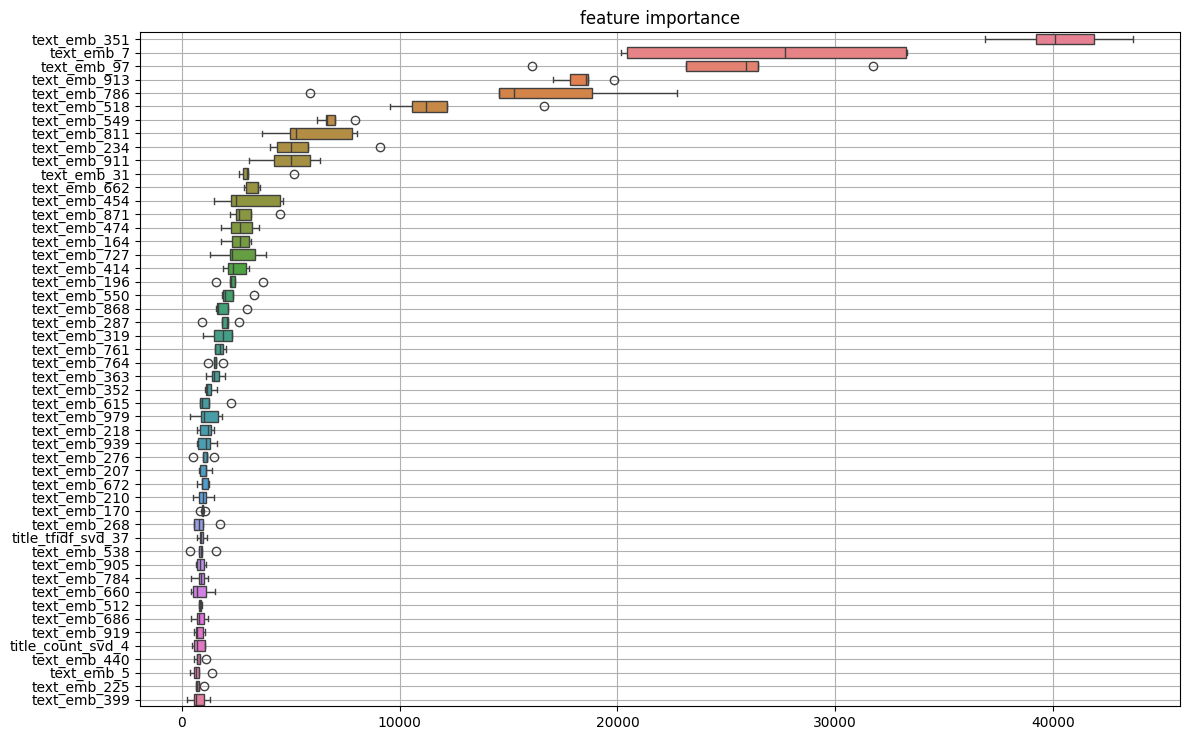

In [29]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_dir}/feature_importance.png")


### oof

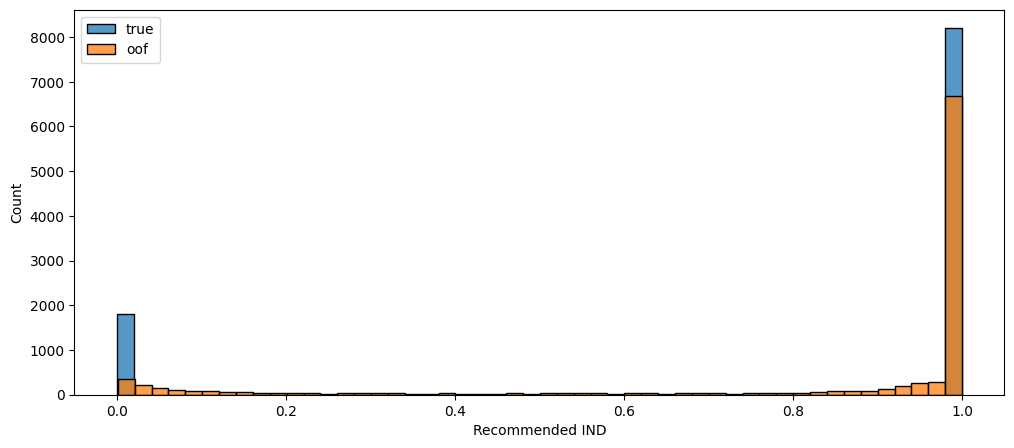

In [30]:
oof = np.zeros(len(x_train))

# 各fold毎に推論してoofを作成
for i, (_, valid_idx) in enumerate(skf.split(x_train, y_train)):
    x_valid = x_train.iloc[valid_idx]
    model = cvbooster.boosters[i]
    y_pred = model.predict(x_valid, num_iteration=cvbooster.best_iteration)
    oof[valid_idx] = y_pred

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### Submission

In [31]:
# 推論
x_test = test_df.drop(["Title", "Review Text", "text"]).to_pandas()
y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = y_pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


,target
0,0.999593
1,0.921776
2,0.999785
3,0.248644
4,0.996092


In [ ]:
# TODO: embeddingsを保存しておく（そのほかのCount,Tfidfも）
